In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

In [26]:
from PIL import Image

def read_calibration_data(filepath):
    calibration_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                try:
                    # Convert numerical values to floats
                    calibration_data[key] = float(value)
                except ValueError:
                    # Keep string values as-is
                    calibration_data[key] = value
    return calibration_data

def calculate_offsets(calibration_data):
    # Calculate pixels per meter
    ppm_x = calibration_data["optical-calibration.image-width"] / calibration_data["optical-calibration.region.width"]
    ppm_y = calibration_data["optical-calibration.image-height"] / calibration_data["optical-calibration.region.height"]
    
    # Calculate the global position in pixels
    global_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]*ppm_y #calibration_data["optical-calibration.region.x"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    global_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]*ppm_x #calibration_data["optical-calibration.region.y"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]
    
    # Calculate the offsets
    offset_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    offset_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    
    return ppm_x, ppm_y, global_x, global_y, offset_x, offset_y

def create_composite_image(image_paths, calibration_files, output_path):
    # Read calibration data from files
    calibration_datas = [read_calibration_data(file) for file in calibration_files]
    
    # Load images and rotate them by -90 degrees to align with the global coordinate system
    images = [Image.open(path).rotate(90, expand=True) for path in image_paths]
    
    # Calculate offsets and pixels per meter for each image
    calculations = [calculate_offsets(data) for data in calibration_datas]
    
    # Determine the canvas size
    canvas_width_meters = max([abs(c[2]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[2] is global_x
    canvas_height_meters = max([abs(c[3]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[3] is global_y
    
    # Assume the pixels per meter is the same for both images, as indicated by calibration data
    ppm_x, ppm_y = calculations[0][:2] 
    
    # Create the canvas
    canvas_width_pixels = int(round(canvas_width_meters))
    canvas_height_pixels = int(round(canvas_height_meters))
    canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))
    
    # Paste images onto the canvas
    for (ppm_x, ppm_y, global_x, global_y, offset_x, offset_y), image in zip(calculations, images):
        position_x = int(round((offset_x)))
        position_y = int(round((offset_y)))
        canvas.paste(image, (position_x, position_y))
    
    # Save the composite image
    canvas.save(output_path)
    print(f"Composite image saved to {output_path}")


In [27]:
import os
import glob

# Directory containing the 'tiling_x' folders
parent_directory = './tiling'

# Glob pattern to match folders
folder_pattern = os.path.join(parent_directory, 'tiling-*')
folders = sorted(glob.glob(folder_pattern), key=lambda x: os.path.basename(x).split('-')[1:])

# Lists to hold the paths
image_paths = []
calibration_files = []
tiling_vars = {}

# Iterate through each folder
for folder in folders:
    # Extract folder name to dynamically create variable-like dictionary keys
    folder_name = os.path.basename(folder)
    tiling_vars[folder_name] = folder

    # Find all jpg images in the folder
    jpg_files = glob.glob(os.path.join(folder, 'snapshot-*.jpg'))
    image_paths.extend(jpg_files)

    # Find all calibration files in the folder
    cal_files = glob.glob(os.path.join(folder, 'optical-calibration-*.txt'))
    calibration_files.extend(cal_files)

    # Optionally open the first calibration file found in each folder
    if cal_files:
        first_cal_file = cal_files[0]
        print(f"Opening file: {first_cal_file}")
        # Here you can add your logic to open and process the file

# Output paths for demonstration purposes
output_path = './result.jpg'

# Print variables and paths for verification
print(f"Tiling folder variables: {tiling_vars}")
print(f"Image paths: {image_paths}")
print(f"Calibration files: {calibration_files}")
print(f"Output path: {output_path}")





Opening file: ./tiling/tiling-13.08.10.162/optical-calibration-2024.02.08-13.08.21-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-13.08.35.698/optical-calibration-2024.02.08-13.08.51-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-13.09.09.241/optical-calibration-2024.02.08-13.09.25-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-13.09.42.115/optical-calibration-2024.02.08-13.09.57-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-13.10.09.570/optical-calibration-2024.02.08-13.10.18-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-14.37.51.173/optical-calibration-2024.02.08-14.38.00-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-14.38.27.466/optical-calibration-2024.02.08-14.38.55-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-14.39.09.233/optical-calibration-2024.02.08-14.39.15-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-14.39.29.081/optical-calibration-2024.02.08-14.39.36-snapshot-000.jpk-opt-

In [28]:
calibrations = []
for file in calibration_files:
    calibration_data = read_calibration_data(file)
    calibrations.append(calibration_data)

calculations = []
for calibration in calibrations:
    calculation_data = calculate_offsets(calibration)
    calculations.append(calculation_data)

In [29]:
df = pd.DataFrame(calculations, columns = ['ppm_x', 'ppm_y', 'global_x', 'global_y', 'x in m', 'y in um'])

In [30]:
df['ppm_x'][0]

406636.9237853339

In [31]:
y_max = df.max()[3]
x_max = df.max()[2]
y_min = df.min()[3]
df['y_offset'] = abs(df['global_y']-abs(y_max))
df['x_offset'] = abs((df['global_x']-x_max))

/tmp/ipykernel_11372/116515729.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_max = df.max()[3]
/tmp/ipykernel_11372/116515729.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_max = df.max()[2]
/tmp/ipykernel_11372/116515729.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_min = df.min()[3]


In [32]:
df

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset
0,406636.923785,406617.234921,-1211.389577,2647.955560,-0.002979,-0.002979,302.807282,3471.429590
1,406636.923785,406617.234921,-236.004778,2644.163698,-0.000580,-0.000580,306.599144,2496.044792
2,406636.923785,406617.234921,-1215.860711,2205.729630,-0.002990,-0.002990,745.033211,3475.900725
3,406636.923785,406617.234921,-222.184907,2825.902236,-0.000546,-0.000546,124.860605,2482.224921
4,406636.923785,406617.234921,-199.558256,2407.917140,-0.000491,-0.000491,542.845702,2459.598270
5,406636.923785,406617.234921,-1217.351090,2950.762842,-0.002994,-0.002994,0.000000,3477.391103
6,406636.923785,406617.234921,744.122133,2803.760470,0.001830,0.001830,147.002372,1515.917880
7,406636.923785,406617.234921,755.570948,2554.580953,0.001858,0.001858,396.181889,1504.469066
8,406636.923785,406617.234921,777.249176,2262.201292,0.001912,0.001912,688.561549,1482.790837
9,406636.923785,406617.234921,895.666500,1940.366988,0.002203,0.002203,1010.395854,1364.373513


In [33]:
canvas_width_pixels = df['y_offset'].max()+1024 #c[2] is global_x
canvas_height_pixels = df['x_offset'].max()+1024 #c[3] is global_y

# Create the canvas
canvas_width_pixels = int(canvas_width_pixels)
canvas_height_pixels = int(canvas_height_pixels)
canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))


# List to hold the cropped images
cropped_images = []

# Loop through each image path
for path in image_paths:
    # Open and rotate the image (though here rotation is set to 0, so it's not actually changing the image)
    image = Image.open(path).rotate(0, expand=True)
    
    # Get the size of the image
    width, height = image.size
    
    # Define the cropping box. Remove the right 200 pixels
    crop_box = (0, 0, width - 100, height)
    
    # Crop the image
    cropped_img = image.crop(crop_box)
    # Add the cropped image to the list
    cropped_images.append(cropped_img)

df['image_path'] = cropped_images


In [34]:
# Step 2: Sort the DataFrame by 'y_offset' in descending order
df_sorted = df.sort_values(by='y_offset', ascending=False)
df_sorted = df_sorted.sort_values(by='x_offset', ascending=True)
df_sorted.loc[df_sorted['x_offset'] > 3000, 'x_offset'] -= 100
# df_sorted.loc[df_sorted['x_offset'] > 1800, 'y_offset'] += 100
# df_sorted.loc[df_sorted['x_offset'] < 100, 'y_offset'] -= 20
# df_sorted.loc[df_sorted['x_offset'] > 1000, 'x_offset'] -= 30
# df_sorted.loc[df_sorted['x_offset'] > 1000, 'y_offset'] += 10

In [35]:
df_sorted

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset,image_path
13,406636.923785,406617.234921,2260.040014,1679.270190,0.005558,0.005558,1271.492652,0.000000,<PIL.Image.Image image mode=L size=924x1024 at...
16,406636.923785,406617.234921,2248.252477,1154.300410,0.005529,0.005529,1796.462432,11.787537,<PIL.Image.Image image mode=L size=924x1024 at...
15,406636.923785,406617.234921,2118.725061,1076.025540,0.005211,0.005211,1874.737301,141.314953,<PIL.Image.Image image mode=L size=924x1024 at...
14,406636.923785,406617.234921,2110.866703,1002.829058,0.005191,0.005191,1947.933784,149.173311,<PIL.Image.Image image mode=L size=924x1024 at...
12,406636.923785,406617.234921,1892.661783,1358.993258,0.004655,0.004655,1591.769584,367.378231,<PIL.Image.Image image mode=L size=924x1024 at...
10,406636.923785,406617.234921,1396.230348,1572.827201,0.003434,0.003434,1377.935641,863.809666,<PIL.Image.Image image mode=L size=924x1024 at...
11,406636.923785,406617.234921,1393.452825,1648.529022,0.003427,0.003427,1302.233820,866.587189,<PIL.Image.Image image mode=L size=924x1024 at...
9,406636.923785,406617.234921,895.666500,1940.366988,0.002203,0.002203,1010.395854,1364.373513,<PIL.Image.Image image mode=L size=924x1024 at...
8,406636.923785,406617.234921,777.249176,2262.201292,0.001912,0.001912,688.561549,1482.790837,<PIL.Image.Image image mode=L size=924x1024 at...
7,406636.923785,406617.234921,755.570948,2554.580953,0.001858,0.001858,396.181889,1504.469066,<PIL.Image.Image image mode=L size=924x1024 at...


In [36]:
# Assuming `df` is your DataFrame and `cropped_images` is a list of image paths
# Step 1: Add the image paths to the DataFrame
df_sorted = df_sorted.sort_values(by='y_offset', ascending=False)

# Now you can loop through the sorted DataFrame
for i, row in df_sorted.iterrows():
    position_x = int(row['x_offset'])
    position_y = int(row['y_offset'])

    
    # Paste the image on the canvas at the specified position
    # Note: Adjust the order of position_x and position_y if necessary
    canvas.paste(row['image_path'], (position_y, position_x))

# Save the composite image
output_path = './result_new.jpg'
canvas.save(output_path)
print(f"Composite image saved to {output_path}")


Composite image saved to ./result_new.jpg


In [37]:
afm = pd.read_csv("./ZWV10_processed-new_forcecurves.tsv", sep = "\t")
afm['X Position'] = abs((afm['X Position'])*df['ppm_x'][0]*(-1))

afm['Y Position'] = abs(((afm['Y Position'])*df['ppm_x'][1]*(-1)))




In [38]:
afm['Filename'] = afm['Filename'].str.split('-data', n=1, expand=True)[0]
afm = afm[afm['Filename'] != 'ZWV10_Location-1']
afm = afm[afm['Filename'] != 'ZWV10_Location-2']
afm = afm[afm['Filename'] != 'ZWV10_Location-3']

#afm_sorted = afm.sort_values(by='Filename', ascending=True)
tiling_3 = ['ZWV10_Location-31', 'ZWV10_Location-32', 'ZWV10_Location-33', 'ZWV10_Location-34', 'ZWV10_Location-35', 'ZWV10_Location-36', 'ZWV10_Location-37', 'ZWV10_Location-38', 'ZWV10_Location-39', 'ZWV10_Location-40', 'ZWV10_Location-41', 'ZWV10_Location-42', 'ZWV10_Location-43', 'ZWV10_Location-43_2', 'ZWV10_Location-43_1', 'ZWV10_Location-44', 'ZWV10_Location-45', 'ZWV10_Location-46', 'ZWV10_Location-47']
tiling_1 = ['ZWV10_Location-1', 'ZWV10_Location-1 new', 'ZWV10_Location-2 new', 'ZWV10_Location-3 new', 'ZWV10_Location-4', 'ZWV10_Location-5', 'ZWV10_Location-6', 'ZWV10_Location-7', 'ZWV10_Location-8', 'ZWV10_Location-9', 'ZWV10_Location-10']
afm_1 = afm[afm['Filename'].isin(tiling_1)] #1-11
afm_3 = afm[afm['Filename'].isin(tiling_3)] #31-45
afm_2 = afm[~afm['Filename'].isin(tiling_1)] #12-30
afm_2 = afm_2[~afm_2['Filename'].isin(tiling_3)] #12-30
afm_11 = afm[afm['Filename'].isin(['ZWV10_Location-11'])]

# offset_x = min(afm_2['X Position'])-max(afm_1['X Position'])
# Loc_6 = afm[afm['Filename'] == 'ZWV08_Location-6']
# Loc_14 = afm_2[afm_2['Filename'] == 'ZWV08_Location-14']

# # Find the maximum value in 'Y position' column of the filtered DataFrame
# max_y_6 = Loc_6['Y Position'].max()
# max_y_14 = Loc_14['Y Position'].max()

# offset_y = max_y_14-max_y_6

# afm_1['X Position'] += offset_x
# afm_1['Y Position'] += offset_y
# afm_1

In [39]:
afm_1['X Position'] = abs(afm_1['X Position'])
afm_1['Y Position'] = abs(afm_1['Y Position'])

offset_x = min(afm_1['X Position'])-max(afm_1['X Position'])
offset_y = min(afm_1['Y Position'])-max(afm_1['Y Position'])

max_y = max(afm_1['Y Position'])
afm_1['X Position'] = abs(afm_1['X Position'])
afm_1['Y Position'] = abs(afm_1['Y Position'])*(-1)+max_y+800


max_y = max(afm_3['Y Position'])
afm_3['X Position'] = abs(afm_3['X Position'])+2650
afm_3['Y Position'] = abs(afm_3['Y Position'])*(-1)+max_y+350

max_y = max(afm_2['Y Position'])
afm_2['X Position'] = abs(afm_2['X Position'])
afm_2['Y Position'] = abs(afm_2['Y Position'])*(-1)+max_y+350

# offset_x = min(afm_2['X Position'])-max(afm_1['X Position'])
# Loc_6 = afm[afm['Filename'] == 'ZWV08_Location-6']
# Loc_14 = afm_2[afm_2['Filename'] == 'ZWV08_Location-14']

# Find the maximum value in 'Y position' column of the filtered DataFrame
min_x_3 = afm_3['X Position'].min()
max_x_2 = afm_2['X Position'].max()

offset_x = min_x_3-max_x_2

afm_2['X Position'] += offset_x

min_x_2 = afm_2['X Position'].min()
min_x_11 = afm_11['X Position'].min()

offset_x = min_x_2-min_x_11

afm_11['X Position'] += offset_x

min_x_11 = afm_11['X Position'].min()
max_x_1 = afm_1['X Position'].max()

offset_x = min_x_11-max_x_1

afm_1['X Position'] += offset_x

/tmp/ipykernel_11372/3998385785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afm_1['X Position'] = abs(afm_1['X Position'])
/tmp/ipykernel_11372/3998385785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afm_1['Y Position'] = abs(afm_1['Y Position'])
/tmp/ipykernel_11372/3998385785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [40]:
afm = pd.concat([afm_3, afm_2, afm_1, afm_11])

In [41]:
afm

,Filename,Position Index,X Position,Y Position,Baseline Offset [N],Contact Point Offset [m],Young's Modulus [Pa],Contact Point [m],Baseline [N],ResidualRMS [N]
0,ZWV10_Location-35,0,3555.913872,518.115903,-3.170000e-10,0.000004,575.81,-5.710000e-07,2.820000e-10,3.190000e-11
1,ZWV10_Location-35,1,3555.909805,521.930158,-3.070000e-10,0.000005,2477.49,-2.350000e-06,4.100000e-10,4.000000e-11
2,ZWV10_Location-35,2,3555.901672,525.740346,-1.600000e-10,0.000005,2788.63,-2.150000e-06,5.840000e-10,4.650000e-11
3,ZWV10_Location-35,3,3555.897606,529.554600,-1.000000e-09,0.000005,1368.42,-1.490000e-06,1.190000e-09,2.290000e-11
4,ZWV10_Location-35,4,3555.889473,533.364788,-7.910000e-10,0.000006,1138.72,-1.680000e-06,6.540000e-10,1.980000e-11
...,...,...,...,...,...,...,...,...,...,...
28395,ZWV10_Location-11,1019,2871.645995,1757.521382,-1.110000e-09,NaN,NaN,NaN,NaN,NaN
28396,ZWV10_Location-11,1020,2871.653314,1753.715260,-1.100000e-09,NaN,NaN,NaN,NaN,NaN
28397,ZWV10_Location-11,1021,2871.660634,1749.913205,-1.090000e-09,NaN,NaN,NaN,NaN,NaN
28398,ZWV10_Location-11,1022,2871.667953,1746.107083,-1.080000e-09,NaN,NaN,NaN,NaN,NaN


In [42]:
afm.to_csv("./ZWV10_new/afm.csv", sep = ",")

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


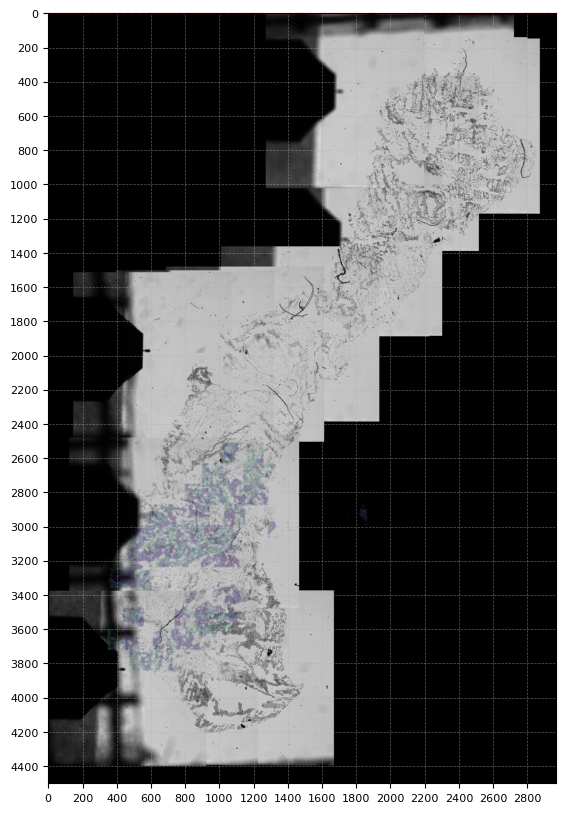

In [43]:
# Filter the data to exclude outliers
filtered_afm = afm[afm["Young's Modulus [Pa]"] < 10000]
filtered_afm = filtered_afm[filtered_afm["Young's Modulus [Pa]"] > 10]

afm_slide = cv2.imread('./result_new.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.1, alpha=0.1)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.savefig('Location_all.png', bbox_inches='tight')

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")

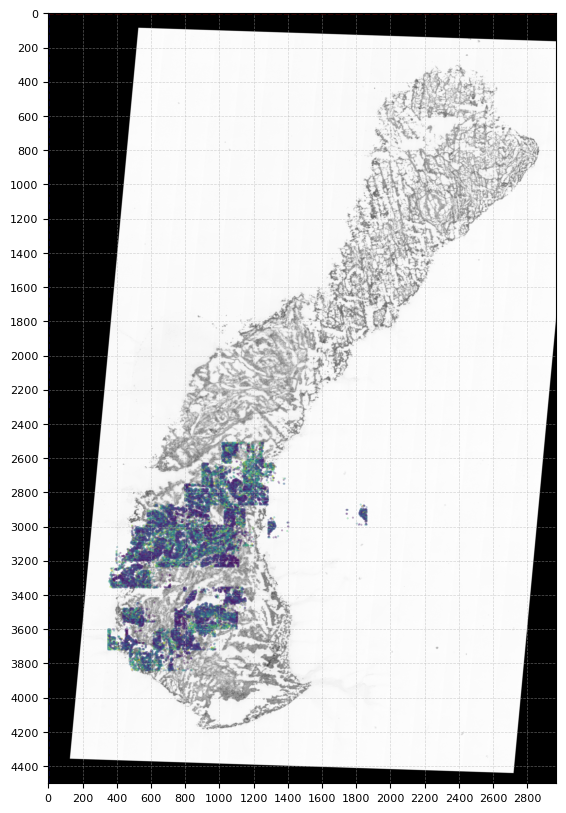

In [44]:
afm_slide = cv2.imread('./ZWV10_new/transformed_image-new2.tif', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.3, alpha= 0.3)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")

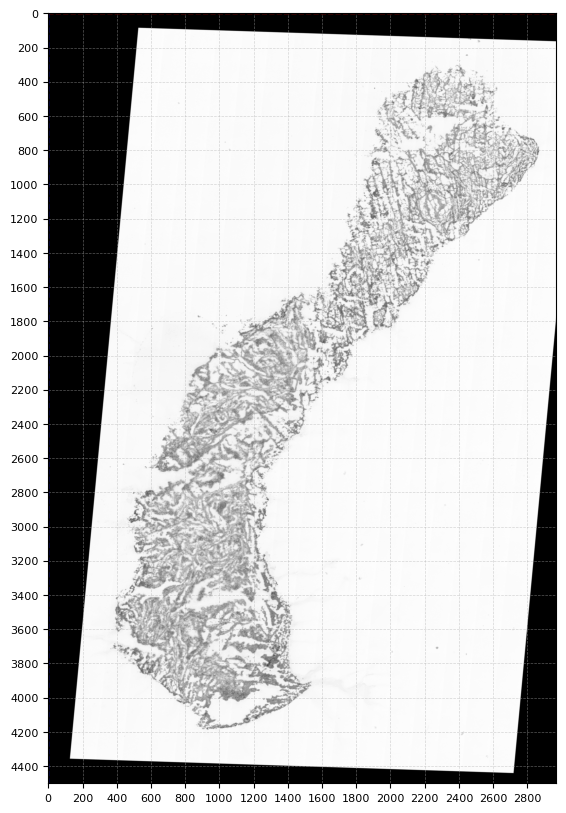

In [46]:
afm_slide = cv2.imread('./ZWV10_new/transformed_image-new2.tif', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap



    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")